## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold, cross_val_score, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
from math import pi

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Loading the dataset

In [2]:
df = pd.read_csv("../data/clean/cleaned_data_filtered.csv")
print(f"Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")

Dataset chargé : 3953 lignes, 8 colonnes


## Creating new engineered features

In [3]:
df['room_bathroom_ratio'] = df['room_count'] / np.maximum(df['bathroom_count'], 1)
df['total_rooms'] = df['room_count'] + df['bathroom_count']
df['size_per_room'] = df['size'] / np.maximum(df['room_count'], 1)
df['bathroom_density'] = df['bathroom_count'] / np.maximum(df['size'], 1)
df['size_x_rooms'] = df['size'] * df['room_count']
df['size_x_bathrooms'] = df['size'] * df['bathroom_count']

In [4]:
# Locations premium et upscale
high_value_locations = ['tunis', 'ariana', 'ben arous', 'la manouba']
upscale_locations = ['nabeul', 'sousse', 'monastir', 'mahdia', 'bizerte']

# Encoding the features ( Binary flags to indicate luxuriousness of location)
df['is_premium_location'] = df['location'].str.lower().isin(high_value_locations).astype(int)
df['is_upscale_location'] = df['location'].str.lower().isin(upscale_locations).astype(int)


**Creating a synthetic indicator of property luxury:**

| Feature          | Weight | Meaning                       |
| ---------------- | ------ | ----------------------------- |
| Size             | 0.30   | Larger = more luxury          |
| Rooms            | 0.20   | More rooms = more valuable    |
| Bathrooms        | 0.20   | More bathrooms = more upscale |
| Premium location | 0.30   | Strong impact on price        |
| Upscale location | 0.15   | Smaller impact                |


In [5]:
# Luxury score
df['luxury_score'] = (
        (df['size'] / 100) * 0.3 +
        (df['room_count'] / 5) * 0.2 +
        (df['bathroom_count'] / 2) * 0.2 +
        df['is_premium_location'] * 0.3 +
        df['is_upscale_location'] * 0.15
)

Transforming the continuous score into 3 categories: standard, upscale, luxury.

In [6]:
# Property tier
df['property_tier'] = pd.cut(df['luxury_score'],
                             bins=3,
                             labels=['standard', 'upscale', 'luxury'])

Replacing infinities and NaNs :

In [7]:
engineered_cols = ['room_bathroom_ratio', 'total_rooms', 'size_per_room',
                   'bathroom_density', 'size_x_rooms', 'size_x_bathrooms',
                   'luxury_score', 'is_premium_location', 'is_upscale_location']
for col in engineered_cols:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(df[col].median())

This function:
- Computes price statistics per location (median, mean, std)
- But only using *train data* (to avoid data leakage) and adds location_price_level to train and test

In [8]:
def add_location_features(df_train, df_test, df_full):
    """Ajoute les statistiques de location en évitant le data leakage"""
    # Calculer sur train uniquement
    location_stats = df_train.groupby('location').agg({
        'price': ['median', 'mean', 'std', 'count']
    })
    location_stats.columns = ['location_price_median', 'location_price_mean',
                              'location_price_std', 'location_count']
    location_stats = location_stats.reset_index()

    # Normaliser les stats de prix
    location_stats['location_price_level'] = (
            location_stats['location_price_median'] / location_stats['location_price_median'].median()
    )

    # Merger sur train et test
    df_train_merged = df_train.merge(location_stats[['location', 'location_price_level']],
                                     on='location', how='left')
    df_test_merged = df_test.merge(location_stats[['location', 'location_price_level']],
                                   on='location', how='left')

    # Remplir les valeurs manquantes
    global_median = location_stats['location_price_level'].median()
    df_train_merged['location_price_level'] = df_train_merged['location_price_level'].fillna(global_median)
    df_test_merged['location_price_level'] = df_test_merged['location_price_level'].fillna(global_median)

    return df_train_merged, df_test_merged, location_stats

print(" Fonction add_location_features définie")

 Fonction add_location_features définie


## Modèles

Configuration des Modèles et Grilles de Paramètres

We created a dictionary that contains all the machine learning models we want to try, along with the hyperparameters we want to test for each model.

**Régression linéaire:**

La prédiction d'une régression linéaire s'écrit :

$$
\hat{y} = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b
$$

ou sous forme vectorielle :

$$
\hat{y} = \mathbf{w}^\top \mathbf{x} + b
$$

où :
- $x_1, x_2, \dots, x_n$ sont les features
- $w_1, w_2, \dots, w_n$ sont les coefficients appris
- $b$ est l'intercept (le biais)


**Régression Ridge:**

La régression Ridge est une régression linéaire régularisée, c’est-à-dire :

Elle ajoute une pénalité sur les coefficients pour éviter l’overfitting.
Sa formule de coût :

$$
J(w) = \|y - Xw\|^2 + \alpha \|w\|^2
$$


* Plus alpha est grand, plus le modèle réduit les coefficients.

* Plus alpha est petit, plus le modèle se rapproche d’une régression linéaire normale (sans régularisation).
* Solver :
| Solver       | Définition                                           |
| ------------ | ------------------------------------------------------------ |
| **auto**     | Choisit automatiquement le meilleur solver selon les données |
| **svd**      | Stable et précis, utilise la décomposition SVD               |
| **cholesky** | Très rapide si les données sont bien conditionnées           |
| **lsqr**     | Optimisé pour les grandes matrices clairsemées (sparse)      |


**KNeighborsRegressor:**

Le modèle k-NN Regression prédit le prix d'une maison en regardant les k maisons les plus similaires dans ton dataset (les "voisins").

* La prédiction = moyenne des prix des voisins (ou moyenne pondérée).

* Le paramètre weights contrôle si tous les voisins ont le même poids (uniform) ou si les voisins les plus proches influencent plus la prédiction (distance).

* L' algorithme: méthode utilisée pour chercher efficacement les voisins :

            'auto' → laisse scikit-learn choisir automatiquement

            'ball_tree' → rapide quand ton dataset est assez grand

            'kd_tree' → rapide si features peu nombreuses


**DecisionTreeRegressor:**

Le modèle apprend des règles en arbre pour prédire la valeur cible.

1️⃣ max_depth : Profondeur maximale de l’arbre.

2️⃣ min_samples_split : Nombre minimum d’échantillons requis pour diviser un noeud.

3️⃣ min_samples_leaf : Nombre minimum d’échantillons dans une feuille (fin d’un chemin).

4️⃣ max_features : Nombre maximum de features à considérer à chaque division.


In [9]:
models_config = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            'fit_intercept': [True, False],  # Détermine si le modèle doit apprendre le terme constant b (l’offset).
            'positive': [False, True]        # contrainte de positivité sur tous les coefficients
        }
    },
    "Ridge": {
        "model": Ridge(random_state=42),
        "params": {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Strength of regularization
            'fit_intercept': [True, False],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr']   # Algorithm used to solve the linear regression
        }
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(),
        "params": {
            'n_neighbors': [3, 5, 7, 10, 15, 20],
            'weights': ['uniform', 'distance'],
            'p': [1, 2],        # Distance metric: 1 = Manhattan / 2 = Euclidean
            'algorithm': ['auto', 'ball_tree', 'kd_tree']
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            'max_depth': [5, 10, 15, 20, 25, 30],   # Limit the depth of the tree
            'min_samples_split': [5, 10, 20, 30],   # Minimum samples needed to split
            'min_samples_leaf': [2, 5, 10, 15],     # Minimum samples per leaf
            'max_features': ['sqrt', 'log2', None]  # Number of features used at each split
        }
    }
}


In [10]:
categorical_cols = ['category', 'type', 'location', 'property_tier']

print("✓ Configuration des modèles:")
for name, config in models_config.items():
    n_combinations = np.prod([len(v) for v in config['params'].values()])
    print(f"  • {name}: {n_combinations} combinaisons à tester")

✓ Configuration des modèles:
  • Linear Regression: 4 combinaisons à tester
  • Ridge: 48 combinaisons à tester
  • KNeighbors: 72 combinaisons à tester
  • Decision Tree: 288 combinaisons à tester


**Optimisation des Hyperparamètres:**

In [11]:
optimized_models = {}
optimization_results = []

for name, config in models_config.items():
    print(f"\n{'='*80}")
    print(f"Optimisation: {name}")
    print(f"{'='*80}")

    n_combinations = np.prod([len(v) for v in config['params'].values()])
    print(f"Nombre de combinaisons à tester: {n_combinations}")

    start_time = time.time()

    # Cross-validation 3-fold pour l'optimisation
    kf_opt = KFold(n_splits=3, shuffle=True, random_state=42)
    best_score = -np.inf
    best_params = None
    best_estimator = None

    # Grid Search manuel
    param_grid = list(ParameterGrid(config['params']))

    for i, params in enumerate(param_grid):
        if i % 10 == 0:
            print(f"  Progress: {i}/{len(param_grid)}...", end='\r')

        scores = []
        for train_idx, test_idx in kf_opt.split(df):
            # Split data
            df_train_fold = df.iloc[train_idx].copy()
            df_test_fold = df.iloc[test_idx].copy()

            # Add location features
            df_train_fold, df_test_fold, _ = add_location_features(
                df_train_fold, df_test_fold, df
            )

            # One-hot encoding
            df_train_encoded = pd.get_dummies(df_train_fold, columns=categorical_cols, drop_first=False)
            df_test_encoded = pd.get_dummies(df_test_fold, columns=categorical_cols, drop_first=False)

            # Align columns
            missing_cols = set(df_train_encoded.columns) - set(df_test_encoded.columns)
            for col in missing_cols:
                df_test_encoded[col] = 0
            df_test_encoded = df_test_encoded[df_train_encoded.columns]

            # Features and target
            feature_cols_fold = [col for col in df_train_encoded.columns
                                 if col not in ['price', 'log_price']]
            X_train_fold = df_train_encoded[feature_cols_fold]
            y_train_fold = df_train_encoded['log_price']
            X_test_fold = df_test_encoded[feature_cols_fold]
            y_test_fold = df_test_encoded['log_price']

            # Scale
            scaler_fold = StandardScaler()
            num_cols_fold = ['room_count', 'bathroom_count', 'size', 'room_bathroom_ratio',
                             'total_rooms', 'size_per_room', 'bathroom_density',
                             'size_x_rooms', 'size_x_bathrooms', 'luxury_score',
                             'is_premium_location', 'location_price_level', 'is_upscale_location']
            num_cols_present = [col for col in num_cols_fold if col in X_train_fold.columns]
            X_train_fold[num_cols_present] = scaler_fold.fit_transform(X_train_fold[num_cols_present])
            X_test_fold[num_cols_present] = scaler_fold.transform(X_test_fold[num_cols_present])

            # Train and score
            model_fold = config['model'].__class__(**params)
            if hasattr(model_fold, 'random_state'):
                model_fold.random_state = 42
            if hasattr(model_fold, 'n_jobs'):
                model_fold.n_jobs = -1

            model_fold.fit(X_train_fold, y_train_fold)
            score = model_fold.score(X_test_fold, y_test_fold)
            scores.append(score)

        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = params
            best_estimator = config['model'].__class__(**params)
            if hasattr(best_estimator, 'random_state'):
                best_estimator.random_state = 42
            if hasattr(best_estimator, 'n_jobs'):
                best_estimator.n_jobs = -1

    elapsed = time.time() - start_time

    print(f"\n  ✓ Terminé en {elapsed:.1f}s")
    print(f"  Meilleur score R²: {best_score:.4f}")
    print(f"  Meilleurs paramètres:")
    for param, value in best_params.items():
        print(f"    • {param}: {value}")

    optimized_models[name] = best_estimator

    optimization_results.append({
        'Model': name,
        'Best_R2': best_score,
        'Best_Params': best_params,
        'Time_seconds': elapsed
    })

print("\n" + "="*80)
print("✓ Optimisation terminée pour tous les modèles")



Optimisation: Linear Regression
Nombre de combinaisons à tester: 4
  Progress: 0/4...
  ✓ Terminé en 0.3s
  Meilleur score R²: 0.9653
  Meilleurs paramètres:
    • fit_intercept: True
    • positive: False

Optimisation: Ridge
Nombre de combinaisons à tester: 48
  Progress: 40/48...
  ✓ Terminé en 3.3s
  Meilleur score R²: 0.9654
  Meilleurs paramètres:
    • alpha: 1.0
    • fit_intercept: True
    • solver: lsqr

Optimisation: KNeighbors
Nombre de combinaisons à tester: 72
  Progress: 70/72...
  ✓ Terminé en 15.3s
  Meilleur score R²: 0.9104
  Meilleurs paramètres:
    • algorithm: ball_tree
    • n_neighbors: 10
    • p: 1
    • weights: distance

Optimisation: Decision Tree
Nombre de combinaisons à tester: 288
  Progress: 280/288...
  ✓ Terminé en 19.5s
  Meilleur score R²: 0.9626
  Meilleurs paramètres:
    • max_depth: 10
    • max_features: None
    • min_samples_leaf: 15
    • min_samples_split: 5

✓ Optimisation terminée pour tous les modèles


On a utilisé le score R² (ou coefficient de détermination) qui est  est une métrique mesurant à quel point un modèle de régression explique la variance des données.

optimized_models : contient le meilleur modèle entraîné pour chaque type.

optimization_results : contient les informationss sur les performances (R², paramètres, temps).

In [12]:
print(optimized_models)

{'Linear Regression': LinearRegression(n_jobs=-1), 'Ridge': Ridge(random_state=42, solver='lsqr'), 'KNeighbors': KNeighborsRegressor(algorithm='ball_tree', n_jobs=-1, n_neighbors=10, p=1,
                    weights='distance'), 'Decision Tree': DecisionTreeRegressor(max_depth=10, min_samples_leaf=15, min_samples_split=5,
                      random_state=42)}


## Préparation des Données Finales

In [13]:
# Calculer location_price_level sur l'ensemble complet on regroupe le dataset par location et on calcule la médiane des prix pour chaque location.

location_stats_full = df.groupby('location')['price'].median().reset_index()

# Creation d'une colonne --> le niveau de prix relatif
location_stats_full['location_price_level'] = (
        location_stats_full['price'] / location_stats_full['price'].median()
)
df_final = df.merge(location_stats_full[['location', 'location_price_level']],
                    on='location', how='left')
df_final['location_price_level'] = df_final['location_price_level'].fillna(1.0)

# One-hot encoding
df_encoded = pd.get_dummies(df_final, columns=categorical_cols, drop_first=False)

# Features et target
feature_cols = [col for col in df_encoded.columns if col not in ['price', 'log_price']]
X = df_encoded[feature_cols].copy()
y = df_encoded['log_price'].copy()

In [14]:
# Standardisation
num_cols = ['room_count', 'bathroom_count', 'size', 'room_bathroom_ratio',
            'total_rooms', 'size_per_room', 'bathroom_density',
            'size_x_rooms', 'size_x_bathrooms', 'luxury_score',
            'is_premium_location', 'is_upscale_location', 'location_price_level']

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print(f" Features finales: {X.shape[1]} colonnes")
print(f" Target: log10(price)")

 Features finales: 45 colonnes
 Target: log10(price)


In [15]:
X.columns

Index(['size', 'bathroom_count', 'room_count', 'room_bathroom_ratio',
       'total_rooms', 'size_per_room', 'bathroom_density', 'size_x_rooms',
       'size_x_bathrooms', 'is_premium_location', 'is_upscale_location',
       'luxury_score', 'location_price_level', 'category_Appartements',
       'category_Bureaux et Plateaux', 'category_Colocations',
       'category_Locations de vacances', 'category_Maisons et Villas',
       'type_À Louer', 'type_À Vendre', 'location_ariana',
       'location_ben arous', 'location_bizerte', 'location_béja',
       'location_gabès', 'location_gafsa', 'location_jendouba',
       'location_kairouan', 'location_kasserine', 'location_la manouba',
       'location_le kef', 'location_mahdia', 'location_monastir',
       'location_médenine', 'location_nabeul', 'location_sfax',
       'location_siliana', 'location_sousse', 'location_tataouine',
       'location_tozeur', 'location_tunis', 'location_zaghouan',
       'property_tier_standard', 'property_tier_ups

## Évaluation Finale avec 5-Fold Cross-Validation


In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
final_results = {}

for name, model in optimized_models.items():
    print(f"\nÉvaluation finale: {name}...")

    # Cross-validation scores
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    # Prédictions pour métriques détaillées
    y_pred_log = np.zeros_like(y)
    for train_idx, test_idx in kf.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred_log[test_idx] = model.predict(X.iloc[test_idx])

    # Métriques log-space
    rmse_log = np.sqrt(mean_squared_error(y, y_pred_log))
    mae_log = mean_absolute_error(y, y_pred_log)
    r2_log = r2_score(y, y_pred_log)

    # Back-transform avec bias correction
    y_actual = 10 ** y
    y_pred_raw = 10 ** y_pred_log

    df_temp = pd.DataFrame({
        'actual_log': y.values,
        'pred_log': y_pred_log,
        'type': df['type'].values
    })

    bias_factors = {}
    for prop_type in df_temp['type'].unique():
        mask = df_temp['type'] == prop_type
        mean_actual = np.mean(df_temp.loc[mask, 'actual_log'])
        mean_pred = np.mean(df_temp.loc[mask, 'pred_log'])
        bias_factors[prop_type] = 10 ** (mean_actual - mean_pred)

    y_pred_corrected = np.array([
        y_pred_raw[i] * bias_factors[df['type'].iloc[i]]
        for i in range(len(y_pred_raw))
    ])

    # Métriques espace réel
    rmse_actual = np.sqrt(mean_squared_error(y_actual, y_pred_corrected))
    mae_actual = mean_absolute_error(y_actual, y_pred_corrected)
    mape = np.mean(np.abs((y_actual - y_pred_corrected) / y_actual) * 100)

    final_results[name] = {
        'R2_log': r2_log,
        'R2_std': r2_scores.std(),
        'RMSE_log': rmse_log,
        'MAE_log': mae_log,
        'RMSE_actual': rmse_actual,
        'MAE_actual': mae_actual,
        'MAPE': mape
    }

print("\n✓ Évaluation finale terminée")


Évaluation finale: Linear Regression...

Évaluation finale: Ridge...

Évaluation finale: KNeighbors...

Évaluation finale: Decision Tree...

✓ Évaluation finale terminée


On calcule les métriques les plus parlantes pour le meilleur modèle :

R² → qualité globale de la régression

MAE → erreur moyenne absolue en TND

MAPE → erreur relative moyenne en pourcentage

## Tableau Récapitulatif des Performances


In [17]:
results_df = pd.DataFrame(final_results).T
results_df = results_df.sort_values('R2_log', ascending=False)

print("\n" + "=" * 100)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES FINALES")
print("=" * 100)
print("\n", results_df.round(4).to_string())

# Identifier le meilleur
best_model_name = results_df['R2_log'].idxmax()
best_model = optimized_models[best_model_name]

print("\n" + "=" * 100)
print(f"Le meilleur modèle est: {best_model_name}")
print(f"   • R² = {results_df.loc[best_model_name, 'R2_log']:.4f}")
print(f"   • MAE = {results_df.loc[best_model_name, 'MAE_actual']:,.0f} TND")
print(f"   • MAPE = {results_df.loc[best_model_name, 'MAPE']:.2f}%")
print("=" * 100)


TABLEAU RÉCAPITULATIF DES PERFORMANCES FINALES

                    R2_log  R2_std  RMSE_log  MAE_log  RMSE_actual  MAE_actual      MAPE
Ridge              0.9653  0.0017    0.2328   0.1621  176219.6573  73455.6553   52.9821
Linear Regression  0.9653  0.0017    0.2330   0.1622  176164.8014  73481.9344   53.0935
Decision Tree      0.9632  0.0009    0.2399   0.1704  172731.1172  73969.6803   54.5144
KNeighbors         0.9146  0.0072    0.3653   0.2370  217043.7516  94415.8910  111.5170

Le meilleur modèle est: Ridge
   • R² = 0.9653
   • MAE = 73,456 TND
   • MAPE = 52.98%


## Visualisations Comparatives

#### Comparaison des R² scores

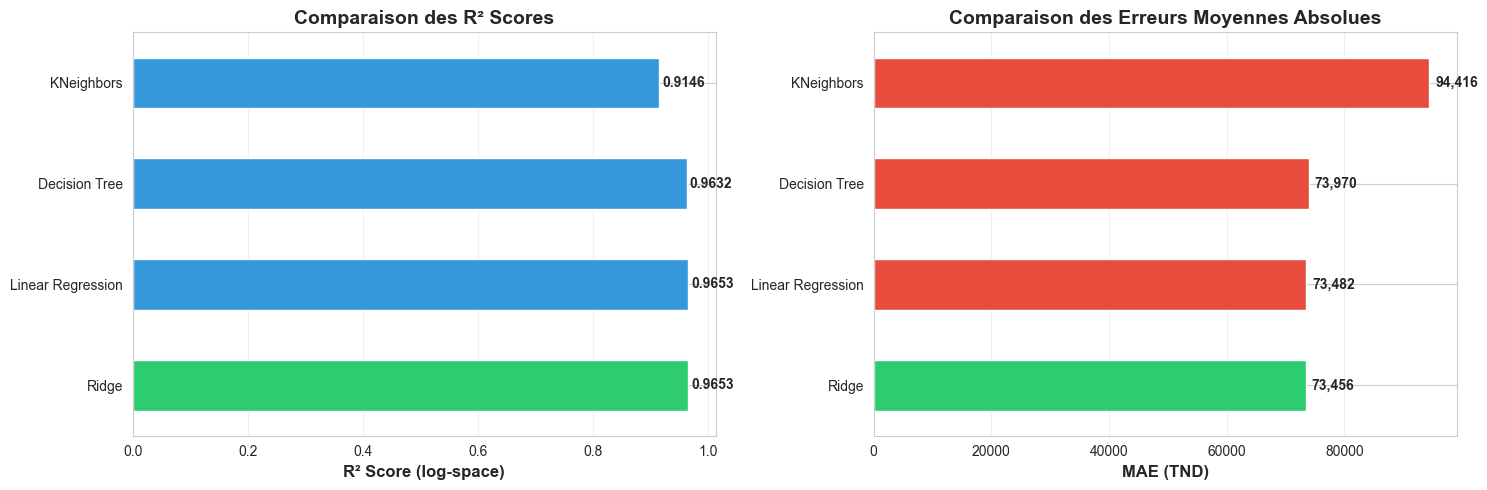

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# R² scores
ax1 = axes[0]
colors = ['#2ecc71' if x == results_df['R2_log'].max() else '#3498db'
          for x in results_df['R2_log']]
results_df['R2_log'].plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('R² Score (log-space)', fontsize=12, fontweight='bold')
ax1.set_title('Comparaison des R² Scores', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['R2_log']):
    ax1.text(v + 0.005, i, f'{v:.4f}', va='center', fontweight='bold')

# MAE
ax2 = axes[1]
colors = ['#2ecc71' if x == results_df['MAE_actual'].min() else '#e74c3c'
          for x in results_df['MAE_actual']]
results_df['MAE_actual'].plot(kind='barh', ax=ax2, color=colors)
ax2.set_xlabel('MAE (TND)', fontsize=12, fontweight='bold')
ax2.set_title('Comparaison des Erreurs Moyennes Absolues', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['MAE_actual']):
    ax2.text(v + 1000, i, f'{v:,.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


#### Temps d'optimisation vs Performance

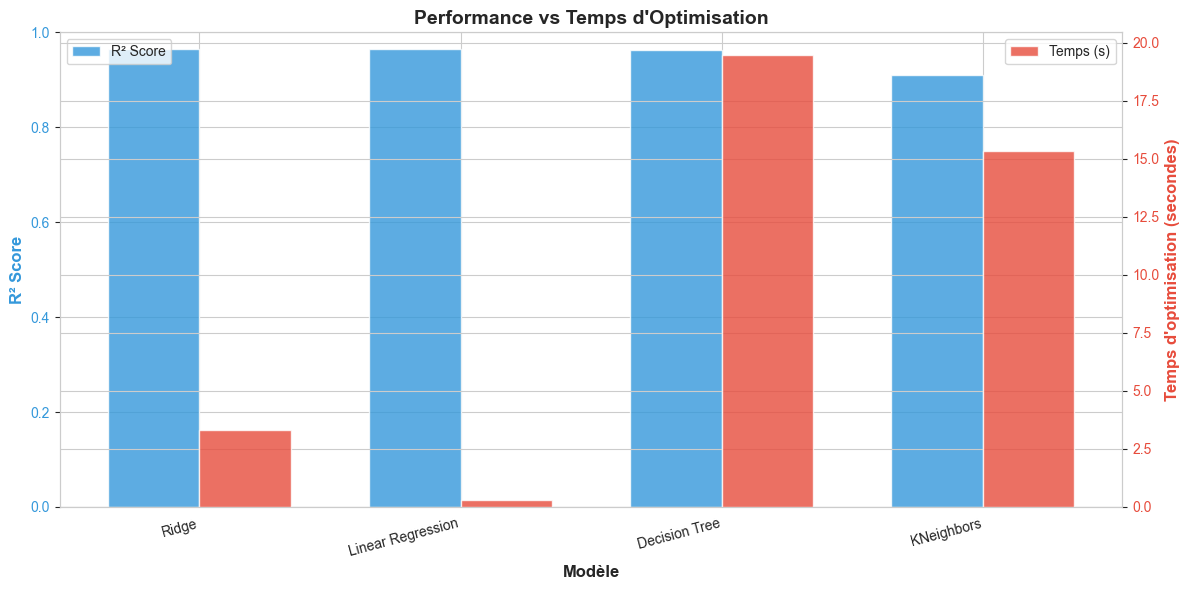

In [19]:
opt_df = pd.DataFrame(optimization_results)
opt_df = opt_df.sort_values('Best_R2', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(opt_df))
width = 0.35

ax1 = ax
bars1 = ax1.bar(x - width/2, opt_df['Best_R2'], width, label='R² Score', color='#3498db', alpha=0.8)
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold', color='#3498db')
ax1.tick_params(axis='y', labelcolor='#3498db')
ax1.set_ylim([0, 1])

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, opt_df['Time_seconds'], width, label='Temps (s)', color='#e74c3c', alpha=0.8)
ax2.set_ylabel('Temps d\'optimisation (secondes)', fontsize=12, fontweight='bold', color='#e74c3c')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

ax1.set_xlabel('Modèle', fontsize=12, fontweight='bold')
ax1.set_title('Performance vs Temps d\'Optimisation', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(opt_df['Model'], rotation=15, ha='right')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Plus le R² est grand, le modéle a une meilleure capacité à expliquer la variance des prix.
Plus le temps de performance est grand → plus l’optimisation est coûteuse en temps.

#### Radar chart pour comparer toutes les métriques

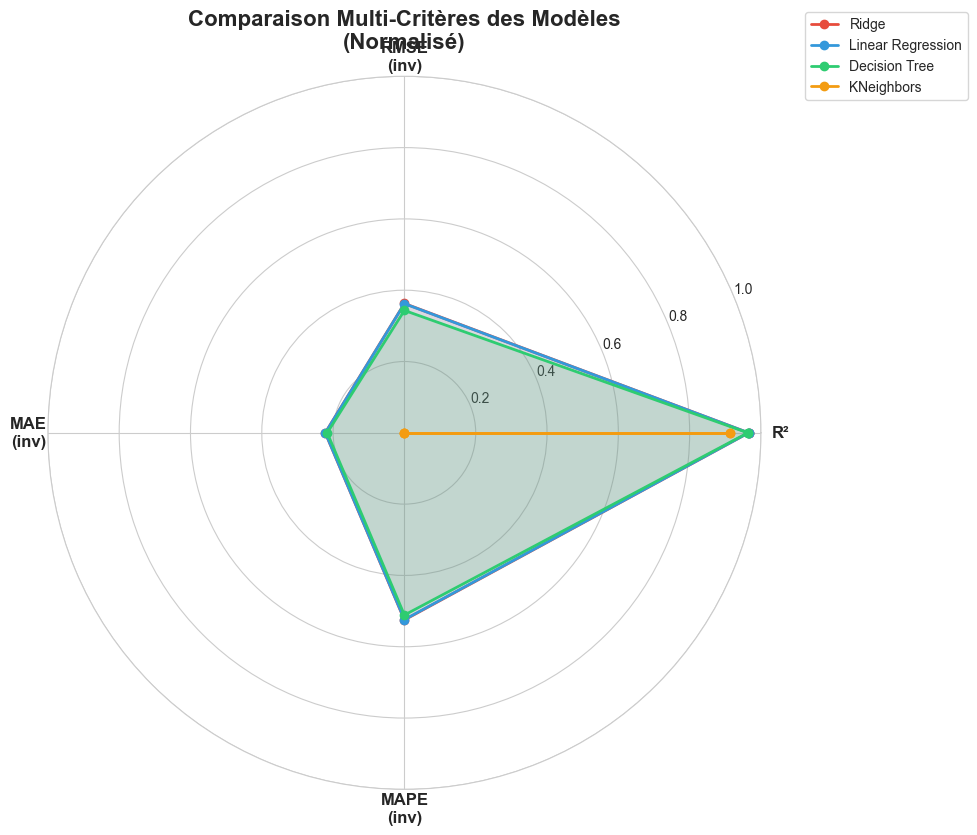

In [20]:
# Normaliser les métriques pour le radar chart
metrics_normalized = results_df.copy()
metrics_normalized['R2_log'] = results_df['R2_log']
metrics_normalized['RMSE_inv'] = 1 - (results_df['RMSE_log'] / results_df['RMSE_log'].max())
metrics_normalized['MAE_inv'] = 1 - (results_df['MAE_actual'] / results_df['MAE_actual'].max())
metrics_normalized['MAPE_inv'] = 1 - (results_df['MAPE'] / results_df['MAPE'].max())

categories = ['R²', 'RMSE\n(inv)', 'MAE\n(inv)', 'MAPE\n(inv)']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for idx, (model_name, row) in enumerate(metrics_normalized.iterrows()):
    values = [row['R2_log'], row['RMSE_inv'], row['MAE_inv'], row['MAPE_inv']]
    values += values[:1]

    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True)
ax.set_title('Comparaison Multi-Critères des Modèles\n(Normalisé)',
             size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

In [21]:
print(metrics_normalized[['R2_log','RMSE_inv','MAE_inv','MAPE_inv']])


                     R2_log  RMSE_inv   MAE_inv  MAPE_inv
Ridge              0.965327  0.362814  0.221999  0.524897
Linear Regression  0.965261  0.362212  0.221721  0.523898
Decision Tree      0.963171  0.343299  0.216555  0.511157
KNeighbors         0.914600  0.000000  0.000000  0.000000


**RADAR CHART contenant Ridge seul**


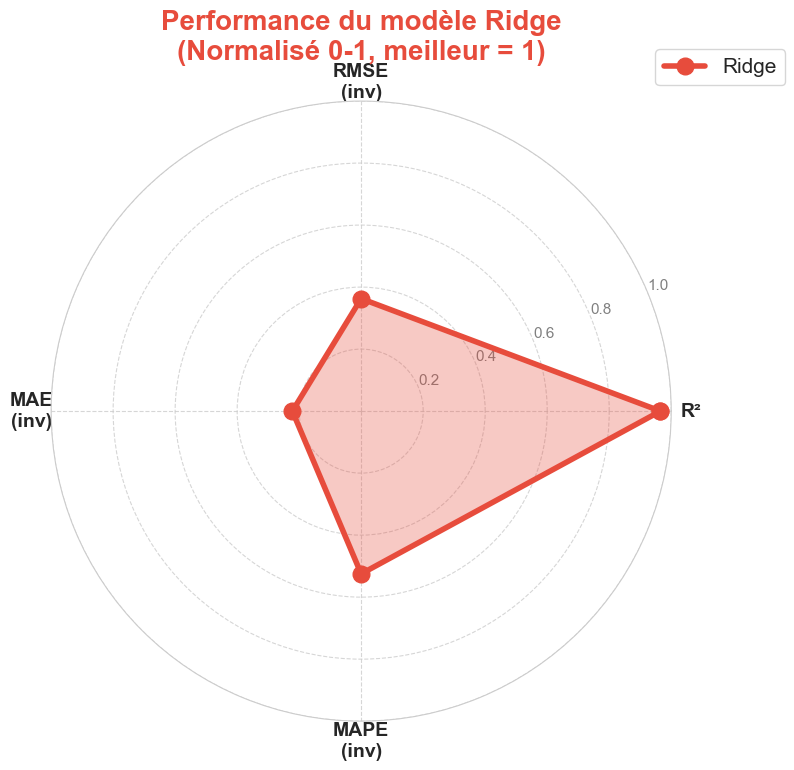

In [22]:
ridge_values = metrics_normalized.loc['Ridge'][['R2_log', 'RMSE_inv', 'MAE_inv', 'MAPE_inv']].tolist()
ridge_values += ridge_values[:1]  # fermer le radar

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

ax.plot(angles, ridge_values, 'o-', linewidth=4, color='#e74c3c', label='Ridge', markersize=12)
ax.fill(angles, ridge_values, color='#e74c3c', alpha=0.3)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=14, fontweight='bold')

ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])          # CORRIGÉ ici
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=11, color='gray')

ax.grid(True, alpha=0.8, linestyle='--')
ax.set_title('Performance du modèle Ridge\n(Normalisé 0-1, meilleur = 1)',
             size=20, fontweight='bold', color='#e74c3c', pad=30)

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=15, fancybox=True)

plt.tight_layout()
plt.show()

#### Analyse des Résultats

In [23]:
print("\n" + "="*80)
print("ANALYSE COMPARATIVE DES MODÈLES")
print("="*80)

for i, (name, row) in enumerate(results_df.iterrows(), 1):
    print(f"\n{i}. {name}")
    print(f"   {'─'*60}")
    print(f"   Performance:")
    print(f"     • R² Score: {row['R2_log']:.4f} (±{row['R2_std']:.4f})")
    print(f"     • RMSE: {row['RMSE_actual']:,.0f} TND")
    print(f"     • MAE: {row['MAE_actual']:,.0f} TND")
    print(f"     • MAPE: {row['MAPE']:.2f}%")

    # Trouver les meilleurs paramètres
    opt_result = [r for r in optimization_results if r['Model'] == name][0]
    print(f"   Temps d'optimisation: {opt_result['Time_seconds']:.1f}s")

    # Points forts/faibles
    if row['R2_log'] == results_df['R2_log'].max():
        print(f"   ⭐ Meilleur R² - Excellent pouvoir prédictif")
    if row['MAE_actual'] == results_df['MAE_actual'].min():
        print(f"   ⭐ Meilleure MAE - Erreurs les plus faibles")
    if row['MAPE'] == results_df['MAPE'].min():
        print(f"   ⭐ Meilleur MAPE - Prédictions les plus précises en %")

print("\n" + "="*80)
print("RECOMMANDATION FINALE")
print("="*80)
print(f"\n Meilleur modèle global: {best_model_name}")
print(f"   Performance: R²={results_df.loc[best_model_name, 'R2_log']:.4f}, "
      f"MAE={results_df.loc[best_model_name, 'MAE_actual']:,.0f} TND")
print("\n" + "="*80)



ANALYSE COMPARATIVE DES MODÈLES

1. Ridge
   ────────────────────────────────────────────────────────────
   Performance:
     • R² Score: 0.9653 (±0.0017)
     • RMSE: 176,220 TND
     • MAE: 73,456 TND
     • MAPE: 52.98%
   Temps d'optimisation: 3.3s
   ⭐ Meilleur R² - Excellent pouvoir prédictif
   ⭐ Meilleure MAE - Erreurs les plus faibles
   ⭐ Meilleur MAPE - Prédictions les plus précises en %

2. Linear Regression
   ────────────────────────────────────────────────────────────
   Performance:
     • R² Score: 0.9653 (±0.0017)
     • RMSE: 176,165 TND
     • MAE: 73,482 TND
     • MAPE: 53.09%
   Temps d'optimisation: 0.3s

3. Decision Tree
   ────────────────────────────────────────────────────────────
   Performance:
     • R² Score: 0.9632 (±0.0009)
     • RMSE: 172,731 TND
     • MAE: 73,970 TND
     • MAPE: 54.51%
   Temps d'optimisation: 19.5s

4. KNeighbors
   ────────────────────────────────────────────────────────────
   Performance:
     • R² Score: 0.9146 (±0.0072)
  

In [25]:
import joblib 

# Sauvegarder le modèle et les objets nécessaires
joblib.dump(best_model, '../output/best_model.pkl')
joblib.dump(scaler, '../output/scaler.pkl')
joblib.dump(feature_cols, '../output/feature_cols.pkl')
joblib.dump(location_stats_full, '../output/location_stats.pkl')

['../output/location_stats.pkl']